In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import date
from workalendar.america import Brazil
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import periodogram

/home/danilofrp/projeto_final/environments/tsa/local/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
def acquireData(path, assetType, asset, samplingFrequency):
    filepath = path + '/' + assetType + '/' + asset + '/' + samplingFrequency + '/' + asset + '.CSV'
    
    df = pd.read_csv(filepath, delimiter=';', decimal=',',
    parse_dates=['Date'], dayfirst=True, index_col='Date')
    df = df.sort_index() #csv entries begin from most recent to older dates
    
    df['Close_r'] = np.log(df.Close/df.Close.shift(1))
    
    return df

In [3]:
def plot_ReturnSeries(df, asset, initialDate = '', finalDate = ''):
    initialDate = initialDate if initialDate else df.index[0].strftime('%Y-%m-%d')
    finalDate = finalDate if finalDate else df.index[-1].strftime('%Y-%m-%d')
    title = asset + ' (' + initialDate + ')' if initialDate == finalDate else asset + ' (' + initialDate + ' to ' + finalDate + ')'
    
    fig, ax = plt.subplots(figsize=(10,10), nrows = 2, ncols = 1, sharex = True)

    plot_data = df[initialDate:finalDate]
    plt.xlabel('Date')
    ax[0].set_title(title)
    ax[0].set_ylabel('Price')
    ax[0].plot(plot_data['Close'])

    ax[1].set_ylabel('Returns')
    ax[1].plot(plot_data['Close_r'])

In [4]:
def plot_seasonalDecompose(title, df, column, initialDate = '', finalDate = '', frequency = 1):
    initialDate = initialDate if initialDate else df.index[0].strftime('%Y-%m-%d')
    finalDate = finalDate if finalDate else df.index[-1].strftime('%Y-%m-%d')
    
    result = seasonal_decompose(df[column][initialDate:finalDate].values, model='additive', freq=frequency, two_sided=False)

    fig, ax = plt.subplots(figsize=(10,15), nrows = 4, ncols = 1)

    plot_data = df[initialDate:finalDate]
    plt.xlabel('Date')
    ax[0].set_title(title)
    ax[0].plot(df[initialDate:finalDate].index,plot_data['Close'],'b-')
    #ax[0].plot(df[initialDate:finalDate].index,plot_data['Open'],'r:')
    ax[0].plot(df[initialDate:finalDate].index,plot_data['High'],'g:')
    ax[0].plot(df[initialDate:finalDate].index,plot_data['Low'],'g:')
    ax[0].grid()

    ax[1].set_title('trend')
    ax[1].plot(df[initialDate:finalDate].index,result.trend)
    ax[1].grid()

    ax[2].set_title('seasonal')
    ax[2].plot(df[initialDate:finalDate].index,result.seasonal)
    ax[2].grid()

    ax[3].set_title('resid')
    ax[3].plot(df[initialDate:finalDate].index,result.resid)
    ax[3].grid()

In [5]:
dataPath = '/home/danilofrp/projeto_final/data'
assetType = 'stocks'
asset = 'PETR4'
frequency = 'diario'

df = acquireData(dataPath, assetType, asset, frequency)

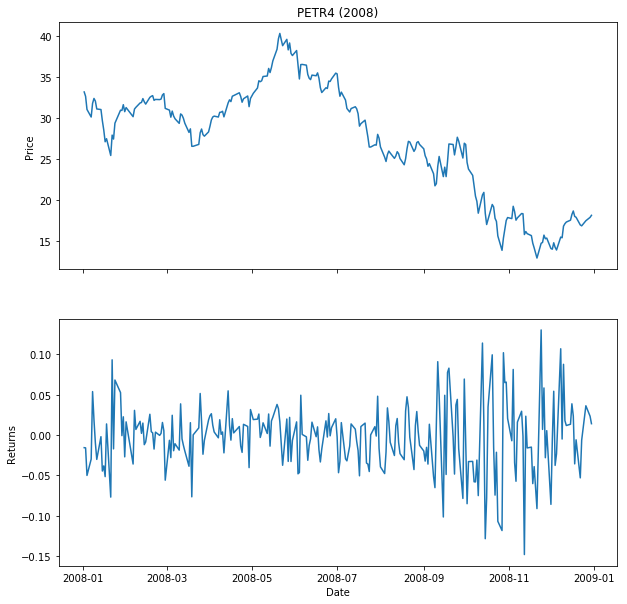

In [6]:
%matplotlib inline

plot_ReturnSeries(df, asset, '2008', '2008')

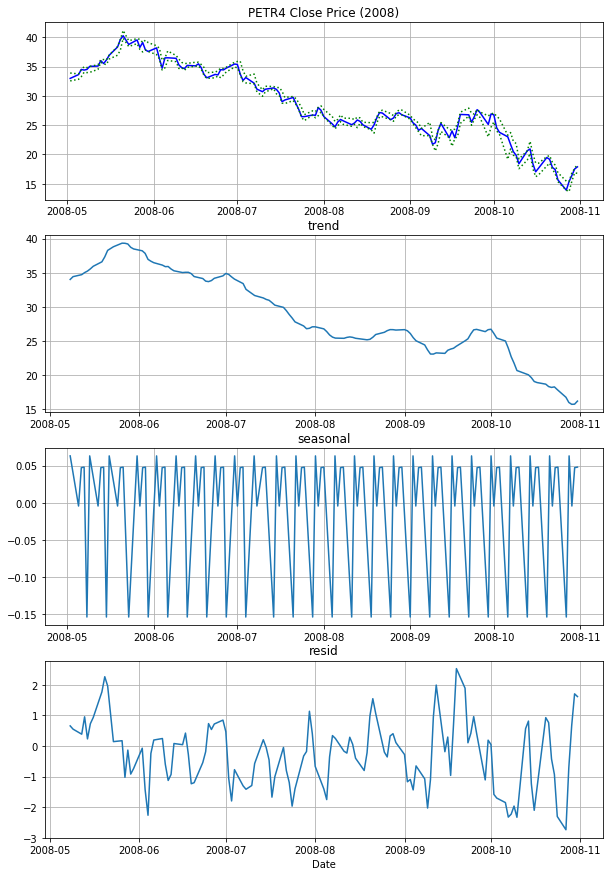

In [8]:
%matplotlib inline
#%matplotlib tk

plot_seasonalDecompose((asset + ' Close Price (2008)'), df, 'Close', '2008-05', '2008-10', 5)

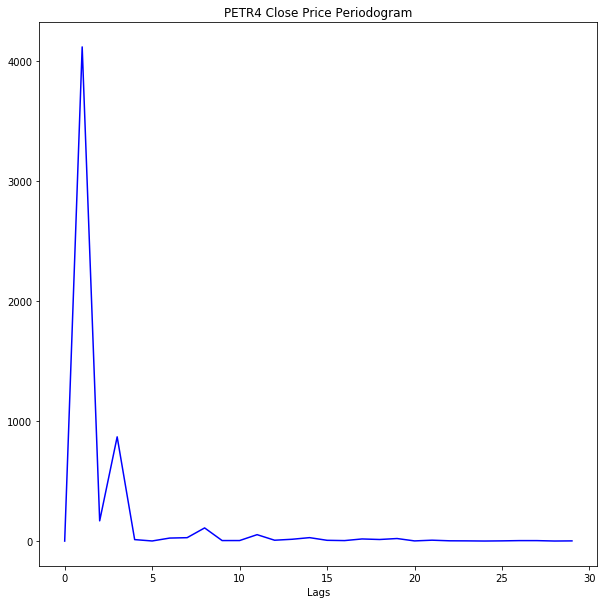

In [9]:
%matplotlib inline
perioGram = periodogram(df['Close']['2008'].values)
#print perioGram[0:30]

fig, ax = plt.subplots(figsize=(10,10), nrows = 1, ncols = 1)
plot_data = perioGram[0:30]
plt.xlabel('Lags')
ax.set_title('PETR4 Close Price Periodogram')
ax.plot(plot_data,'b-')